In [1]:
# ideas for a source test
import cobra
import pandas as pd

from refinegems.utility.io import load_model

/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


In [2]:
test_model_path = '/Users/brune/Documents/11_Test_Data/test_SPECIMEN/thesis/Kp_std/03_refinement/step4-smoothing/Kp_std_smooth.xml'
test_model = load_model(test_model_path,'cobra')


/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/medium/minimal_medium.py:112: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  medium = pd.Series()
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/medium/minimal_medium.py:112: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  medium = pd.Series()
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/medium/minimal_medium.py:112: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  medium = pd.Series()
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/medium/minimal_medium.py:112: FutureWarning: The default dtype for empty Series wi

,model_name,medium_name,growth_value,doubling_time,additives,no_exchange
0,Kp_std,LB,5.565270,7.472922,None,"[EX_pydxn_e, EX_pydx_e, EX_lipt_e, EX_nh3_e, E..."
1,Kp_std,dGMM,3.091088,13.454431,None,"[EX_pydxn_e, EX_4abz_e, EX_lipt_e, EX_hco3_e, ..."
2,Kp_std,SNM3,1.533487,27.120433,[EX_fe3_e],"[EX_pydam_e, EX_4abz_e, EX_cbl1_e, EX_cbl2_e, ..."
3,Kp_std,Blood,13.683503,3.039341,"[EX_cobalt2_e, EX_cu2_e, EX_mg2_e, EX_mn2_e, E...","[EX_doco13ac_e, EX_nrvnc_e, EX_aprgstrn_e, EX_..."
4,Kp_std,CasA,0.853482,48.728433,"[EX_ca2_e, EX_cl_e, EX_cobalt2_e, EX_cu2_e, EX...","[EX_nh3_e, EX_Lcyst_e]"
5,Kp_std,M9,0.878309,47.351048,"[EX_cobalt2_e, EX_cu2_e, EX_fe3_e, EX_mn2_e, E...","[EX_nh3_e, EX_glc__bD_e]"
6,Kp_std,MP-AU,0.558891,74.413132,"[EX_cobalt2_e, EX_cu2_e, EX_fe3_e, EX_mn2_e, E...","[EX_nh3_e, EX_crtn_e, EX_urate_e]"
7,Kp_std,RPMI,2.149382,19.349203,"[EX_cobalt2_e, EX_cu2_e, EX_fe3_e, EX_mn2_e, E...","[EX_pydxn_e, EX_4abz_e, EX_hco3_e, EX_cbl1_e, ..."
8,Kp_std,artSw,1.565586,26.564391,"[EX_cobalt2_e, EX_cu2_e, EX_fe3_e, EX_mg2_e, E...","[EX_hco3_e, EX_glc__bD_e, EX_citr__L_e, EX_orn..."
9,Kp_std,BMS23,1.061478,39.180102,"[EX_cu2_e, EX_fe3_e, EX_mn2_e, EX_mobd_e, EX_z...","[EX_nh3_e, EX_glc__bD_e, EX_nicnt_e]"


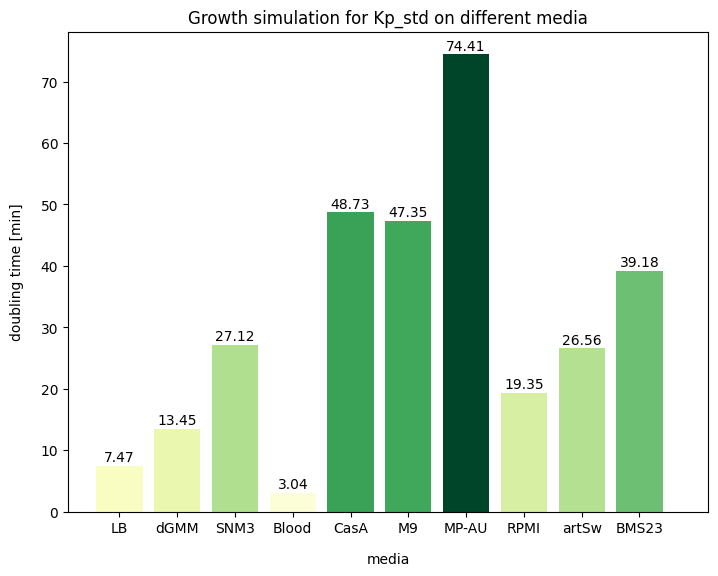

In [3]:
media_config = '/Users/brune/Downloads/AEROBIC_minimal_media_config.yml'

from refinegems.analysis.growth import growth_analysis

report = growth_analysis(test_model,media_config,retrieve='report')
report.plot_growth()
report.to_table()

-----
### Plot the basic analysis

- one model  -  done more or less
- collection of models

#### Plot for a single report

/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarning: invalid character '*' found in formula 'HO*'
  warn(f"invalid character '*' found in formula '{self.formula}'")
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarning: invalid character '*' found in formula 'C8H14NOS2*'
  warn(f"invalid character '*' found in formula '{self.formula}'")
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarning: invalid character '*' found in formula 'HO2*'
  warn(f"invalid character '*' found in formula '{self.formula}'")
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarning: invalid character '*' found in formula 'C8H16NOS2*'
  warn(f"invalid character '*' found in formula '{self.formula}'")
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarning: invalid

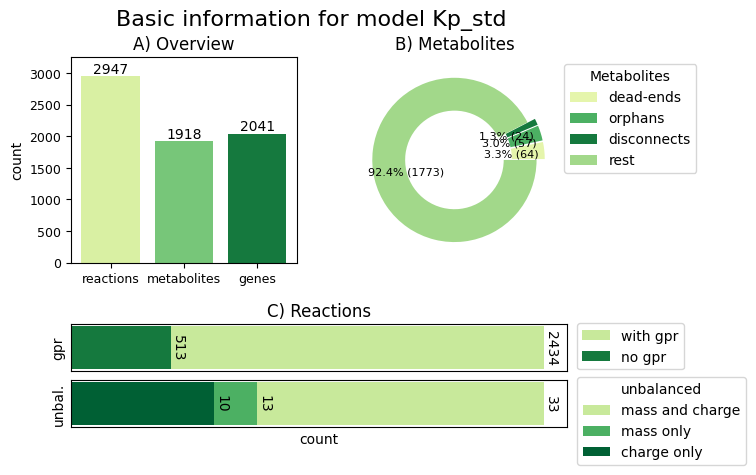

In [4]:
from refinegems.utility.io import load_model
from refinegems.classes.reports import ModelInfoReport
import matplotlib.pyplot as plt

test_model_path = '/Users/brune/Documents/11_Test_Data/test_SPECIMEN/thesis/Kp_std/03_refinement/step4-smoothing/Kp_std_smooth.xml'
test_model = load_model(test_model_path,'cobra')

rep = ModelInfoReport(test_model)
fig = rep.visualise()

plt.show()

In [6]:
import pandas as pd
from refinegems.curation.egcs import GreedyEGCSolver
from refinegems.utility.io import load_model

test_egc = load_model('/Users/brune/Downloads/iJN746.xml','cobra')

greedy_solver = GreedyEGCSolver()
    #greedy_results = greedy_solver.solve_egcs(test_egc)
    #print(greedy_results)
egcs, _ = greedy_solver.find_egcs(test_egc, with_reacs=True)
filtered_result2 = {
                        'ATP': {"RM": ["PTAr", "test5"]},
                        'CTP': {'RB': ['Clt']},
                        'GTP': {'RB': ['Clt'], "RM": ["PTAr", "test5"]},
                        'ITP': {"MR": ["2faffa5"]},
                        'NADH': {'MR': ['check'], "RM": ["asd", "t0"], "RB": ["triple",  "check"]},
                        'FMNH2': {'RB': ['check2']},
                        'ACCOA': {'RB': ['PTAr', 'Clt'], 'RF': ['PTAr'], 'RM': ['PTAr']},
                        'PROTON': {'RB': ['Clt']},
                        "MQL8": {"RM": ["test1"]},
                        "GLU": {'RB': ['PTAr', 'Clt'], 'RF': ['PTAr'], 'RM': ['PTAr']},
                        'UTP':{}
                        }
    
print(egcs)
print('\n\n')
print(_)
# sol, score = greedy_solver.find_solution_greedy(filtered_result2, egcs)
    
# print(sol, score)

solution_table = pd.DataFrame(filtered_result2)[list(egcs.keys())]
print(solution_table)
for col in solution_table.columns:
    solution_table[col] = solution_table[col].apply(lambda x: ', '.join(map(str,x)))

{'ATP': {'ALDD2x_copy2': -1.0, 'ACALD': 1.0, 'ACKr': -1.0, 'PTAr': 1.0}, 'CTP': {'ALDD2x_copy2': -1.0, 'ACALD': 1.0, 'ACKr': -1.0, 'NDPK3': 1.0, 'PTAr': 1.0}, 'GTP': {'ALDD2x_copy2': -1.0, 'ACALD': 1.0, 'ACKr': -1.0, 'NDPK1': 1.0, 'PTAr': 1.0}, 'UTP': {'ALDD2x_copy2': -1.0, 'ACALD': 1.0, 'ACKr': -1.0, 'NDPK2': 1.0, 'PTAr': 1.0}, 'ACCOA': {'ALDD2x_copy2': -0.9999999999999997, 'ACALD': 1.0, 'ACKr': -1.0000000000000002, 'HSERTA': -1.0, 'HSK': 1.0, 'AHSERL2': -1.0, 'PTAr': 1.0000000000000002, 'SHSL2r': 1.0, 'SHSL4r': -0.9999999999999999, 'THRD_L': 0.9999999999999998, 'THRS': 1.0000000000000002}, 'PROTON': {'ALDD2x_copy2': -1.0, 'ATPS4rpp': -1.0, 'ACALD': 1.0000000000000004, 'ACKr': -1.0, 'PTAr': 1.0}}



{'ATP': 1.0000000000000002, 'CTP': 1.0, 'GTP': 0.9999999999999997, 'UTP': 1.0, 'ACCOA': 0.9999999999999998, 'PROTON': 4.000000000000104}
              ATP    CTP            GTP  UTP        ACCOA PROTON
RM  [PTAr, test5]    NaN  [PTAr, test5]  NaN       [PTAr]    NaN
RB            NaN  [Clt

TypeError: 'float' object is not iterable

In [ ]:
from refinegems.analysis.growth import MIN_GROWTH_THRESHOLD

-1.0e-16 < MIN_GROWTH_THRESHOLD * -1.0

False

In [1]:
from refinegems.classes.medium import load_medium_from_db